In [1]:
import sys, os
if os.path.join(os.path.abspath(os.getcwd()), "utils") not in sys.path :
    sys.path.append(os.path.join(os.path.abspath(os.getcwd()), "utils"))

# import functions from my local file
import crystal_utils as cu
# from crystal_utils import find_no_sub_al
from crystal_utils import add_symmetry_bdp

import pandas as pd
import numpy  as np

import freud

from matplotlib import pyplot as plt

import random

import networkx as nx

from datetime import datetime as dt

plt.rc('legend', fontsize=12)
plt.rc('axes', labelsize=16)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

In [2]:
## starting input .CONFIG file with atoms
prod_file = './templates/bdp_template_12101.CONFIG'

## parameters and constants
metal = 'Ag'

## defect atom, typically 'Mg'. 'Li' works too.
defect = 'Mg'

## rule for placing defects: 'unsym', 'symm', 'all', 'Al4'
## 'unsym' is unsymmetric from Hafskjold & Li (1995). This is the 'normal' material
## 'symm' is symmetric from Hafskjold & Li (1995). This is the 'quenched' material
rule = 'unsym'
enforce_d = True if rule == 'symm' else False

## max number of nearest-neighbor defects to count; do not change this.
max_nn = 8

In [4]:
## read the input .CONFIG file & add symmetry elements
phase, intro_line, cell, atoms = cu.read_poly(prod_file, fractional=False)

## find the spacing between planes
planes = cu.get_conduction_planes(atoms, metal, inexact=True)
dz = np.mean(np.diff(planes))

## The count of extra mobile ions per plane
defects_per_plane = int( cu.find_no_sub_al(atoms, x= 1/3 if defect == 'Li' else 2/3) / len(planes) )

## add symmetry to the atoms, e.g. Al1, Al2, etc.
atoms = cu.add_symmetry_bdp(atoms,cell, metal, frac=False)
al4_atoms = atoms.query('symm == "Al4"')
al2_atoms = atoms.query('symm == "Al2"')

## select all possible sites for defect placements, celled defect_sites
if rule == 'all' :
    defect_sites = pd.concat([al4_atoms.copy(deep=True), al2_atoms.copy(deep=True)])
elif rule == 'unsym' : 
    al2a_zs = atoms.query('symm == "Al2"').sort_values(by='z').z.unique()[1::2]
    # print(f'z coordinates of unsymmetric Al(2) sites: {al2a_zs}')
    defect_sites = al2_atoms.query('z in @al2a_zs')
elif rule == 'symm' :
    defect_sites = al2_atoms.copy(deep=True)
elif rule == 'Al4' : 
    defect_sites = al4_atoms.copy(deep=True)

## query defect sites for their 3-6 NN's
box = freud.box.Box.from_matrix(cell)
query_args = dict(mode='nearest', num_neighbors=3 if rule == 'symm' else 6, exclude_ii=True)
que = freud.locality.AABBQuery(box, defect_sites[['x','y','z']].values)
result = que.query(defect_sites[['x','y','z']].values, query_args)

## manipulate result to be an edgelist
edges = list()
for r in result :
    if (r[1], r[0]) not in edges: edges.append((r[0], r[1]))

## create graph of possible defect sites, nxg has connected components = blocks
nxg = nx.from_edgelist(edges)

```exclude``` can only be ```0``` for ```unsym```, but up to ```1``` for ```symm```

(no structures are possible for higher values)

In [ ]:
dict_of_excludes = dict()
start = dt.now()

for exclude in [0]:

    ## dictionary of histograms of paths to Oi-closest sites
    hists_dict = dict()
    
    ## iterate over random seeds
    for seed in range(100) :
        
        ## reset seed
        random.seed(seed)
        
        ## start timer for sanity
        seed_start = dt.now()
    
        ## initialize data structures
        new_atoms = atoms.copy(deep=True)
        broken=False
        
        ## paths to defects: 0-away & 1-away
        all_paths_to_defect_0 = list()  
        all_paths_to_defect_1 = list()
        
        ## paths to defects in all planes
        all_paths_to_def = list() 
        
        ## counts of defect neighbors
        all_counts_0 = np.zeros(max_nn)
        all_counts_1 = np.zeros(max_nn)
        all_counts = np.zeros(max_nn)
        
        ## for each block, pick spots & place Mg
        for sg in [nxg.subgraph(c).copy() for c in nx.connected_components(nxg)] : 
            
            ## if a previous block did not work, short-circuit
            if broken : break
            
            ## pick nodes that will be substituted with Mg at random
            picked, _, past = cu.pick_nodes_from_graph(sg.edges(), defects_per_plane, 
                                exclude=exclude, verbose=False, enforce_odd=True if rule == 'symm' else False)
            
            if len(picked) < defects_per_plane : broken=True; break
            
            ## substitute Mg for Al in the picked nodes 
            defect_indices = defect_sites.iloc[list(picked)].index.values
            new_atoms.loc[defect_indices, 'atom'] = defect
            new_atoms.loc[defect_indices, 'symm'] = defect
            
        ## create a placeholder for the coordinates of the created defects
        defect_pts = new_atoms.query('atom == @defect')[['x', 'y', 'z']].values
        
        ## for every plane, find mid-oxygen sites
        for pl in planes:
            
            ## if something did not work upstream, then short-circuit
            if broken: break
        
            ## get the mobile-ion sites for this plane
            site_pts = cu.get_mobile_ion_sites(atoms, pl, cell)
            num_sites = len(site_pts)
            
            ## find the graph distances to Mg defects above & below the plane
            
            ## get all the mid-oxygen sites in this plane
            mid_oxs, edges, midpts = cu.get_mid_oxygen_sites_freud(site_pts, cell, viz=False)
            
            ## create a proper networkx graph from site-edge list for this plane
            site_graph = nx.from_edgelist(edges)
            path_lengths = cu.path_lengths(site_graph)
            
            ## find the defect closest to each mobile-ion site in this plane
            ## max distance serves to downselect the defects in the closest block
            e0, e1, d0, d1 = cu.get_nearest_points(site_pts, defect_pts, cell, num_nn=6)
            e0 = np.array(e0)[np.array(d0)<dz]
            e1 = np.array(e1)[np.array(d1)<dz]
            
            ## indices of mobile-ion sites; can be combined with checking max distance
            s0 = [x[1] for x in e0]
            s1 = [x[1] for x in e1]
            
            # it will be more tidy for combining distances later to keep placeholder arrays
            if len(s0) > 0:
                all_paths_to_defect_0.append([min(path_lengths[s0, x]) for x in range(num_sites)])
                
                counts_0 = [[s0.count(x) for x in range(num_sites)].count(i) for i in range(max_nn)]
                all_counts_0 += np.array(counts_0)
            else:
                all_paths_to_defect_0.append(np.ones(len(site_pts))*len(site_pts))
            if len(s1) > 0:
                all_paths_to_defect_1.append([min(path_lengths[s1, x])+1 for x in range(num_sites)])
                
                counts_1 = [[s1.count(x) for x in range(num_sites)].count(i) for i in range(max_nn)]
                all_counts_1 += np.array(counts_1)
            else:
                all_paths_to_defect_1.append(np.ones(len(site_pts))*len(site_pts))
                
            # combine path lengths to distance==1 and distance==0 sites taking min()
            this_plane_paths = [min(all_paths_to_defect_0[-1][i], all_paths_to_defect_1[-1][i]) for i in range(num_sites)]
            all_paths_to_def.append(this_plane_paths)   
                
            # combine counts of defect neighbors
            counts = [[(s1+s0).count(x) for x in range(num_sites)].count(i) for i in range(max_nn)]
            all_counts += np.array(counts)
            
        if not broken: 
            ## remove nesting in the path lengths to defect sites
            all_paths_to_def = np.array([x for x in cu.flatten(all_paths_to_def)])
            
            ## save the histogram
            distance_histogram = np.histogram(all_paths_to_def, np.arange(-0.5,0.5+max(map(max,path_lengths))))[0]
            hists_dict[seed] = np.concatenate((all_counts, distance_histogram))
            
            ## show a sign of life
            print(f'({exclude:2d},{seed:2d}) took {(dt.now()-seed_start).total_seconds():4.1f} sec, \
                  total {(dt.now()-start).total_seconds():4.1f} sec')
        else:
            print(f'({exclude:2d},{seed:2d}) took {(dt.now()-seed_start).total_seconds():4.1f} sec, was broken')
        
    ## dataframe with all distances by seed
    dict_of_excludes[exclude] = pd.DataFrame(data = hists_dict)

In [6]:
min_dist=0
max_dist=6

for exclude, distances in dict_of_excludes.items():
    
    if distances.empty: continue
    
    distances = distances.loc[min_dist:max_dist].copy(deep=True)
    
    means = distances.T.mean()
    stds  = distances.T.std()
    
    print('means:\n', means, '\n')
    print('stdev:\n', stds, '\n')
    
    for seed in distances.columns.values:
        distances[seed] -= means            ## mean-zero
        distances[seed] *= distances[seed]  ## this is taking the square
        distances[seed] /= stds             ## divide by stdev to get z-like
        
    most_normal = np.where(distances.sum() == min(distances.sum()))
        
    print(f'most average seed for exclude {exclude} is {dict_of_excludes[exclude].columns[most_normal].values} :')
    print(dict_of_excludes[exclude].loc[:,most_normal[0]])

KeyError: 0

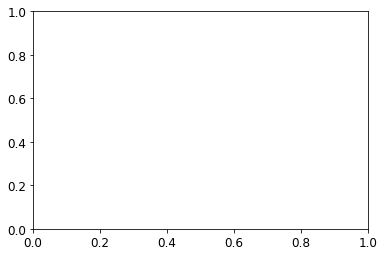

In [7]:
fig, ax = plt.subplots()

for exclude, distances in dict_of_excludes.items() :
    
    if distances.empty: continue
    
    ## plot the average number of sites
    ax.plot(distances.index.values, distances.T.mean(), label=exclude+1)
    
    ## plot the error bars
    ax.fill_between(distances.index.values, distances.T.mean()-distances.T.std(), 
                    distances.T.mean()+distances.T.std(), alpha=0.3)
            
ex = 0
sd = 42
## Plot the chosen structure
ax.scatter(dict_of_excludes[ex].index, dict_of_excludes[ex].loc[:,sd], label = f'seed {sd}',
           zorder=3, marker='*', s=60, c = 'gold', edgecolors='k')

## pretty plot things. Top bound 265 for 116. 295 for 120; 170 for 106
ax.set(xlim=[0,12], ylim=[0,330], ylabel='Number of sites, per 800', xlabel='Distance to $Mg_{Al(2)}^\prime$, sites')
leg = ax.legend(title='min distance\n  between $Mg_{Al(2)}^\prime$')
leg.get_title().set_fontsize(12)
fig.tight_layout()

print(dict_of_excludes[ex].loc[:,sd])